In [1]:
import glob
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
path=glob.glob("/Users/Advaitiyer/Desktop/*csv")[2]
df=pd.read_csv(path,encoding='utf-8',sep='\t')
df=df.loc[:, ~df.columns.str.match('Unnamed')]

In [3]:
df_majority1=df[df.delay_class=='delay']
df_minority=df[df.delay_class=='no_delay']
df_majority2=df[df.delay_class=='extreme_delay']

df_minority_upsampled=resample(df_minority,replace=True,n_samples=len(df_majority1),random_state=123)
df1=pd.concat([df_majority1,df_minority_upsampled,df_majority2])

df1.delay_class.value_counts()

extreme_delay    674715
no_delay         604867
delay            604867
Name: delay_class, dtype: int64

In [13]:
y=df1.pop('delay_class')
X=df1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,train_size=0.1,random_state=42,stratify=y)
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

In [15]:
class_feature_means = pd.DataFrame(columns=['extreme_delay','delay','no_delay'])
for c, rows in train.groupby('delay_class'):
    class_feature_means[c] = rows.mean()

In [16]:
within_class_scatter_matrix = np.zeros((51,51))
for c, rows in train.groupby('delay_class'):
    rows = rows.drop(['delay_class'], axis=1)
    s = np.zeros((51,51))
for index, row in rows.iterrows():
    x, mc = row.values.reshape(51,1), class_feature_means[c].values.reshape(51,1)
    s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s

In [17]:
feature_means = train.mean()
between_class_scatter_matrix = np.zeros((51,51))
for c in class_feature_means:
    n = len(train.loc[train['delay_class'] == c].index)
    mc, m = class_feature_means[c].values.reshape(51,1), feature_means.values.reshape(51,1)
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [18]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [19]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

4.4612723812810516e-05
6.571542892911499e-06
2.881550662892262e-09
1.0398931472388231e-09
8.191820895586519e-10
8.191820895586519e-10
5.914816534713725e-10
5.914816534713725e-10
5.891779686038156e-10
4.134417770475247e-10
2.542540461988123e-10
2.542540461988123e-10
2.1471245565294055e-10
7.058800520811991e-11
4.152353841123769e-20
3.39979425977295e-20
1.1746937178311641e-20
8.312087367260907e-21
8.312087367260907e-21
5.9888799045574774e-21
5.9888799045574774e-21
4.6452952738259835e-21
4.6452952738259835e-21
3.7600431498450666e-21
3.0688898419734958e-21
3.0688898419734958e-21
2.5918065300046486e-21
2.5918065300046486e-21
2.3474087688511395e-21
2.3474087688511395e-21
1.7048373140557103e-21
1.634601851937579e-21
1.634601851937579e-21
1.4911077087090681e-21
1.4298601165668805e-21
1.4298601165668805e-21
1.08230465077953e-21
1.08230465077953e-21
9.050829220890988e-22
9.050829220890988e-22
7.568054077941686e-22
7.568054077941686e-22
7.113640473309242e-22
7.113640473309242e-22
6.18342345289933

In [20]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.8715861881366905
Eigenvector 1: 0.12838637793652935
Eigenvector 2: 5.629604165688353e-05
Eigenvector 3: 2.0316098789984494e-05
Eigenvector 4: 1.6004129176781025e-05
Eigenvector 5: 1.6004129176781025e-05
Eigenvector 6: 1.1555610051181568e-05
Eigenvector 7: 1.1555610051181568e-05
Eigenvector 8: 1.151060361040008e-05
Eigenvector 9: 8.07729525740899e-06
Eigenvector 10: 4.967289508584528e-06
Eigenvector 11: 4.967289508584528e-06
Eigenvector 12: 4.1947766191822926e-06
Eigenvector 13: 1.379057926291684e-06
Eigenvector 14: 8.112336452186269e-16
Eigenvector 15: 6.64208204761894e-16
Eigenvector 16: 2.294965947491833e-16
Eigenvector 17: 1.6239090386607962e-16
Eigenvector 18: 1.6239090386607962e-16
Eigenvector 19: 1.1700305565567843e-16
Eigenvector 20: 1.1700305565567843e-16
Eigenvector 21: 9.07538221040153e-17
Eigenvector 22: 9.07538221040153e-17
Eigenvector 23: 7.345890132047689e-17
Eigenvector 24: 5.995603430089203e-17
Eigenvector 25: 5.995603430089203e-17
Ei

In [21]:
w_matrix = np.hstack((pairs[0][1].reshape(51,1), pairs[1][1].reshape(51,1))).real

In [23]:
X=train.iloc[:,0:51]
y=test.iloc[:,51]
X_lda = np.array(X.dot(w_matrix))

In [24]:
pd.DataFrame(X_lda).to_csv("/Users/advaitiyer/Desktop/lda.csv",encoding='utf-8',sep='\t',index=False)

In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(train['delay_class'])

In [72]:
train['delay_class']

740272          no_delay
22278              delay
315308     extreme_delay
1021564    extreme_delay
99553      extreme_delay
               ...      
1124252    extreme_delay
874333     extreme_delay
484363             delay
1294470            delay
347801          no_delay
Name: delay_class, Length: 188444, dtype: object

In [73]:
y

array([2, 0, 1, ..., 0, 0, 2])

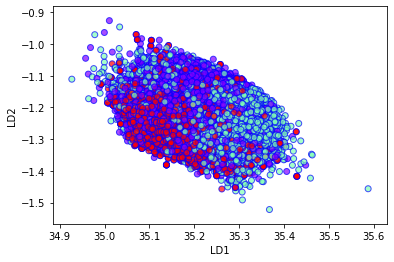

In [26]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

/Users/advaitiyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


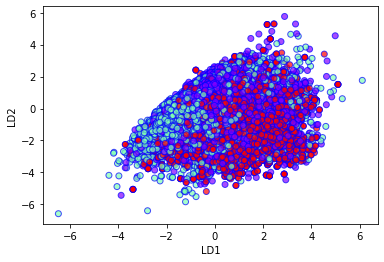

In [29]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

In [31]:
pca.explained_variance_ratio_

array([0.89702336, 0.06445524])

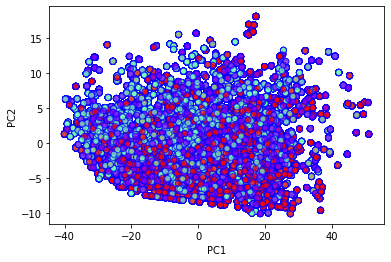

In [32]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

In [74]:
lda_predictions = lda.fit(X_train,y_train).predict(X_test)

# model accuracy for X_test   
accuracy_lda = lda.score(X_test, y_test) 

# creating a confusion matrix 
cm_lda = confusion_matrix(y_test, lda_predictions)

#cohen kappa score
cohen_score_lda = cohen_kappa_score(y_test, lda_predictions)

# precision, recall, f-score, support
precision_lda, recall_lda, fscore_lda, support_lda = score(y_test, lda_predictions)

print(accuracy_lda)
print(cm_lda)
print(cohen_score_lda)
print(precision_lda)
print(recall_lda)
print(fscore_lda)
print(support_lda)

0.6010273609135871
[[ 7172  4548  3337]
 [ 2786 12715  1423]
 [ 4342  2360  8428]]
0.398641709677656
[0.50153846 0.64796412 0.63906582]
[0.4763233  0.75129993 0.557039  ]
[0.48860578 0.69581635 0.59523978]
[15057 16924 15130]


In [75]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)

# model accuracy for X_test   
accuracy_dt = dt.score(X_test, y_test) 

# creating a confusion matrix 
cm_dt = confusion_matrix(y_test, dt_predictions)

#cohen kappa score
cohen_score_dt = cohen_kappa_score(y_test, dt_predictions)

# precision, recall, f-score, support
precision_dt, recall_dt, fscore_dt, support_dt = score(y_test, dt_predictions)

print(accuracy_dt)
print(cm_dt)
print(cohen_score_dt)
print(precision_dt)
print(recall_dt)
print(fscore_dt)
print(support_dt)

0.6547939971556537
[[ 7113  5148  2796]
 [ 5137 10200  1587]
 [  965   630 13535]]
0.48195507710800645
[0.53825199 0.63837777 0.75538565]
[0.47240486 0.6026944  0.8945803 ]
[0.50318336 0.6200231  0.8191116 ]
[15057 16924 15130]


In [66]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,init='random')

y_km=km.fit_predict(X_train)

In [76]:
km_predictions = km.fit(X_train, y_train).predict(X_test)

# model accuracy for X_test   
accuracy_km = km.score(X_test, y_test) 

# creating a confusion matrix 
cm_km = confusion_matrix(y_test, km_predictions)

#cohen kappa score
cohen_score_km = cohen_kappa_score(y_test, km_predictions)

# precision, recall, f-score, support
precision_km, recall_km, fscore_km, support_km = score(y_test, km_predictions)

print(accuracy_km)
print(cm_km)
print(cohen_score_km)
print(precision_km)
print(recall_km)
print(fscore_km)
print(support_km)

-41249.83312239758
[[ 8950  3738  2369]
 [ 3921 11969  1034]
 [ 6111  2070  6949]]
0.38586418685959056
[0.47149932 0.67328571 0.67127125]
[0.59440792 0.70722052 0.45928619]
[0.52586739 0.68983603 0.5454046 ]
[15057 16924 15130]


In [68]:
(8950+11969+6949)/(8950+3738+2369+3921+11969+1034+6111+2070+6949)

0.5915391309885165

In [ ]:
15057
16924
15132

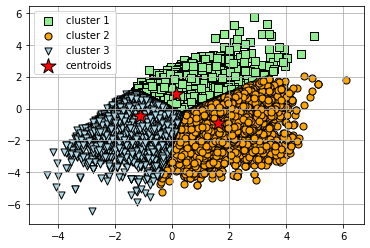

In [37]:
# plot the 3 clusters
plt.scatter(
    X_train[y_km == 0, 0], X_train[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_train[y_km == 1, 0], X_train[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_train[y_km == 2, 0], X_train[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

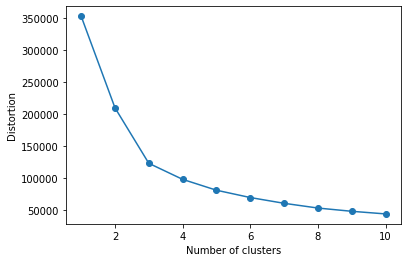

In [38]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_train)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [77]:
from sklearn.svm import SVC

svm_model_linear = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test   
accuracy_svm = svm_model_linear.score(X_test, y_test) 

# creating a confusion matrix 
cm_svm = confusion_matrix(y_test, svm_predictions)

#cohen kappa score
cohen_score_svm = cohen_kappa_score(y_test, svm_predictions)

# precision, recall, f-score, support
precision_svm, recall_svm, fscore_svm, support_svm = score(y_test, svm_predictions)

print(accuracy_svm)
print(cm_svm)
print(cohen_score_svm)
print(precision_svm)
print(recall_svm)
print(fscore_svm)
print(support_svm)

0.6090721912079982
[[ 7022  4082  3953]
 [ 3012 12282  1630]
 [ 3667  2073  9390]]
0.41160015190917754
[0.51251733 0.66616044 0.62712883]
[0.46636116 0.72571496 0.62062128]
[0.48835107 0.69466361 0.62385809]
[15057 16924 15130]


In [78]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy_knn = knn.score(X_test, y_test) 
print(accuracy_knn)
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm_knn = confusion_matrix(y_test, knn_predictions)

#cohen kappa score
cohen_score_knn = cohen_kappa_score(y_test, knn_predictions)

# precision, recall, f-score, support
precision_knn, recall_knn, fscore_knn, support_knn = score(y_test, knn_predictions)

print(accuracy_knn)
print(cm_knn)
print(cohen_score_knn)
print(precision_knn)
print(recall_knn)
print(fscore_knn)
print(support_knn)

0.6017490607289168
[[ 6836  4158  4063]
 [ 3662 11178  2084]
 [ 3155  1640 10335]]
0.4016399877266065
[0.50069582 0.658459   0.62704769]
[0.4540081  0.66048216 0.68307997]
[0.47621038 0.65946903 0.65386562]
[15057 16924 15130]


In [79]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy_gnb = gnb.score(X_test, y_test) 

# creating a confusion matrix 
cm_gnb = confusion_matrix(y_test, gnb_predictions)

#cohen kappa score
cohen_score_gnb = cohen_kappa_score(y_test, gnb_predictions)

# precision, recall, f-score, support
precision_gnb, recall_gnb, fscore_gnb, support_gnb = score(y_test, gnb_predictions)

print(accuracy_gnb)
print(cm_gnb)
print(cohen_score_gnb)
print(precision_gnb)
print(recall_gnb)
print(fscore_gnb)
print(support_gnb)

0.5959966886714355
[[ 7027  4984  3046]
 [ 2516 13066  1342]
 [ 4620  2525  7985]]
0.39034789272657944
[0.49615195 0.63504253 0.64535683]
[0.46669323 0.77203971 0.52775942]
[0.48097194 0.69687192 0.58066393]
[15057 16924 15130]


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

/Users/advaitiyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [80]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fitting Random Forest Classification to the Training set
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 123).fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test) 
  
# accuracy on X_test 
accuracy_rfc = rfc.score(X_test, y_test) 

# creating a confusion matrix 
cm_rfc = confusion_matrix(y_test, rfc_predictions)

#cohen kappa score
cohen_score_rfc = cohen_kappa_score(y_test, rfc_predictions)

# precision, recall, f-score, support
precision_rfc, recall_rfc, fscore_rfc, support_rfc = score(y_test, rfc_predictions)

print(accuracy_rfc)
print(cm_rfc)
print(cohen_score_rfc)
print(precision_rfc)
print(recall_rfc)
print(fscore_rfc)
print(support_rfc)
print(rfc.feature_importances_)

0.6812633992061302
[[ 7728  4650  2679]
 [ 4702 10946  1276]
 [ 1127   582 13421]]
0.5215692771279488
[0.57003762 0.67659785 0.7723872 ]
[0.51324965 0.64677381 0.8870456 ]
[0.54015517 0.66134977 0.82575525]
[15057 16924 15130]
[0.55983094 0.44016906]


In [81]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
# from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sgdc = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000,tol=1e-3,early_stopping=True)).fit(X_train, y_train)
sgdc_predictions = sgdc.predict(X_test)

# accuracy on X_test 
accuracy_sgdc = sgdc.score(X_test, y_test) 

# creating a confusion matrix 
cm_sgdc = confusion_matrix(y_test, sgdc_predictions)

#cohen kappa score
cohen_score_sgdc = cohen_kappa_score(y_test, sgdc_predictions)

# precision, recall, f-score, support
precision_sgdc, recall_sgdc, fscore_sgdc, support_sgdc = score(y_test, rfc_predictions)

print(accuracy_sgdc)
print(cm_sgdc)
print(cohen_score_sgdc)
print(precision_sgdc)
print(recall_sgdc)
print(fscore_sgdc)
print(support_sgdc)

0.5546899874763855
[[  856  8153  6048]
 [  239 14248  2437]
 [  327  3775 11028]]
0.3229613482791034
[0.57003762 0.67659785 0.7723872 ]
[0.51324965 0.64677381 0.8870456 ]
[0.54015517 0.66134977 0.82575525]
[15057 16924 15130]


In [82]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=123).fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)

# accuracy on X_test 
accuracy_gbc = gbc.score(X_test, y_test) 

# creating a confusion matrix 
cm_gbc = confusion_matrix(y_test, gbc_predictions)

#cohen kappa score
cohen_score_gbc = cohen_kappa_score(y_test, gbc_predictions)

# precision, recall, f-score, support
precision_gbc, recall_gbc, fscore_gbc, support_gbc = score(y_test, gbc_predictions)

print(accuracy_gbc)
print(cm_gbc)
print(cohen_score_gbc)
print(precision_gbc)
print(recall_gbc)
print(fscore_gbc)
print(support_gbc)

0.6104094585128739
[[ 6989  3872  4196]
 [ 3096 12067  1761]
 [ 3485  1944  9701]]
0.41400408644307063
[0.51503316 0.67477493 0.6195555 ]
[0.46416949 0.71301111 0.64117647]
[0.48828029 0.69336628 0.63018059]
[15057 16924 15130]
